In [30]:
import pandas as pd
import numpy as np
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

In [107]:
import re
# pip install nltk
import nltk
from collections import defaultdict

nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bartekb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bartekb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [53]:
spotify_df = pd.read_csv('../Data/spotify_modelling.csv')
spotify_df.head(10) 

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,You Proof,Morgan Wallen,1,2022,5,13,2128,9,367814306,37,...,120,A,Major,73,64,85,25,0,61,3
1,Adore You,Harry Styles,1,2019,12,6,13454,1,1439191367,246,...,99,G#,Major,68,57,77,2,0,10,5
2,Piï¿½ï¿½man Deï¿,"Semicenk, Doï¿½ï¿½u",2,2023,6,2,185,3,43522589,5,...,98,A#,Minor,73,45,62,28,0,13,13
3,CORAZï¿½ï¿½N VA,Maria Becerra,1,2023,6,22,370,20,43857627,12,...,98,C#,Major,68,40,79,33,0,30,6
4,Those Eyes,New West,1,2019,5,10,1507,14,411747614,24,...,120,E,Major,60,24,35,73,0,31,3
5,Crown,Kendrick Lamar,1,2022,5,13,1493,0,42485571,2,...,170,C#,Minor,37,14,24,80,0,11,4
6,HUMBLE.,Kendrick Lamar,1,2017,3,30,33206,1,1929770265,284,...,150,C#,Minor,91,42,60,0,0,9,12
7,I Know - PR1SVX Edit,"Kanii, PR1ISVX",2,2023,3,24,407,0,77377503,16,...,134,B,Minor,67,11,76,8,47,30,7
8,Levitating (feat. DaBaby),"Dua Lipa, DaBaby",2,2020,3,27,15894,8,1802514301,198,...,103,F#,Minor,70,92,83,1,0,7,6
9,DOGTOOTH,"Tyler, The Creator",2,2023,3,27,1479,0,80758350,23,...,78,G#,Major,71,80,65,51,0,22,32


# 1. Feature engineering

## TODO
- ogarnąć to jak jest np trzech artystów po przecinku
- brakujące wartości w key i w in_shazam_charts
- jakaś standaryzacja??? box-cox??? to się stosuje w clusteringu???
- encoding???
- usunięcie części kolumn???
- nowe kolumny
- pipeline do zautomatyzowania

## Categorical variables

In [54]:
numeric = ['in_shazam_charts','in_deezer_charts','in_deezer_playlists','in_apple_charts','in_apple_playlists','streams','in_spotify_charts','in_spotify_playlists','bpm', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']
categorical = list(set(spotify_df.columns) - set(numeric))
categorical

['released_month',
 'artist_count',
 'mode',
 'artist(s)_name',
 'released_year',
 'track_name',
 'key',
 'released_day']

Plan:
- ordinal encoding for **key** column
- binary encode **mode**
- try cyclical encoding of **released_month** and **released_day**
- try grouping and ordinal encoding **released_year**
- decide about **artist(s)_name** and **track_name**



key 

We use ordinal encoding for the 'key' column because musical keys have a natural order based on their pitch, which is important for preserving the inherent relationships between them in musical theory. The chosen order reflects the sequence of keys in a chromatic scale, ensuring that the encoding respects the progression from one key to the next in terms of pitch.

In [55]:
spotify_df.key.unique()

array(['A', 'G#', 'A#', 'C#', 'E', 'B', 'F#', 'D', nan, 'F', 'D#', 'G'],
      dtype=object)

In [56]:

key_order = [
    'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', np.nan
]

ordinal_encoder = OrdinalEncoder(categories=[key_order], handle_unknown='use_encoded_value', unknown_value=-1)
spotify_df['key'] = spotify_df['key'].astype(object)
encoded_keys = ordinal_encoder.fit_transform(spotify_df[['key']])

spotify_df['key'] = encoded_keys
spotify_df['key'].fillna(-1, inplace=True)


mode

In [60]:
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(['Major', 'Minor'])
spotify_df['mode'] = label_encoder.fit_transform(spotify_df['mode'])

released_month and released_day

In [62]:
spotify_df['month_sin'] = np.sin(2 * np.pi * spotify_df['released_month'] / 12)
spotify_df['month_cos'] = np.cos(2 * np.pi * spotify_df['released_month'] / 12)

spotify_df['day_sin'] = np.sin(2 * np.pi * spotify_df['released_day'] / 31)
spotify_df['day_cos'] = np.cos(2 * np.pi * spotify_df['released_day'] / 31)

released_year

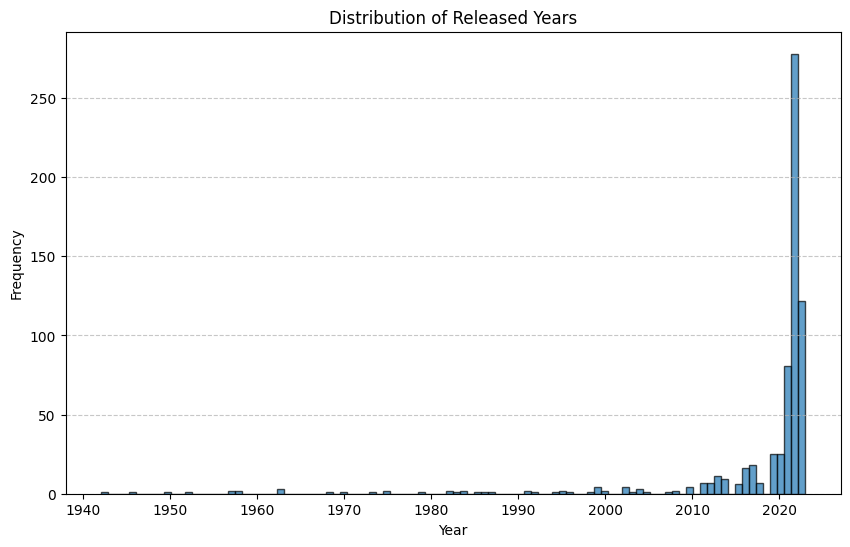

2023
1942


In [73]:
plt.figure(figsize=(10, 6))
plt.hist(spotify_df['released_year'],bins=100, edgecolor='k', alpha=0.7)
plt.title('Distribution of Released Years')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print(max(spotify_df.released_year))
print(min(spotify_df.released_year))

considering histogram above ands trends in music, we will try grouping released_year in intervals:
- [1942 , 1989]
- [1990 , 1999]
- [2000 , 2010]
- [2011 , 2015]
- [2016, 2019]
- 2020
- 2021
- 2022
- 2023

In [74]:
bins = [1942, 1989, 1999, 2010, 2015, 2019, 2020, 2021, 2022, 2023]
labels = ['1942-1989', '1990-1999', '2000-2010', '2011-2015', '2016-2019', '2020', '2021', '2022', '2023']

spotify_df['year_group'] = pd.cut(spotify_df['released_year'], bins=bins, labels=labels, right=True, include_lowest=True)

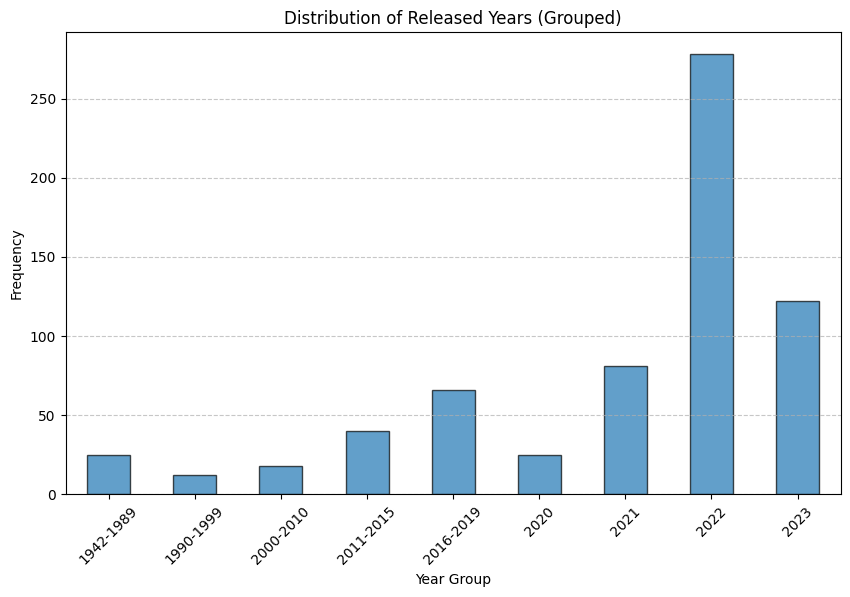

In [76]:
plt.figure(figsize=(10, 6))
spotify_df['year_group'].value_counts().sort_index().plot(kind='bar', edgecolor='k', alpha=0.7)
plt.title('Distribution of Released Years (Grouped)')
plt.xlabel('Year Group')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

In [77]:
ordinal_mapping = {label: idx for idx, label in enumerate(labels)}

spotify_df['year_group_encoded'] = spotify_df['year_group'].map(ordinal_mapping)


Track Name

By simply encoding this variable we will not achieve anything, since almost all songs have different title. We can try to extract keywords, determining what the song is about and label it that way


idk czy to ma sens ale mozna pokazac i tak, nawet jak tego w modelu nie zastosujemy

In [125]:
def preprocess_text(text):
    text = text.lower()  
    text = re.sub(r'\d+', '', text)  
    text = re.sub(r'\W+', ' ', text) 
    tokens = word_tokenize(text) 
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return tokens

spotify_df['processed_track_name'] = spotify_df['track_name'].apply(preprocess_text)

In [119]:
# keywords and song topics generated by chatgpt
topics = {
    'love': ['love', 'romance', 'heart', 'passion', 'affection', 'relationship', 'sweetheart', 'devotion', 'together', 'kiss', 'couples', 'embrace', 'intimacy', 'wedding', 'romantic', 'admiration', 'adoration', 'infatuation', 'commitment', 'tenderness', 'butterflies', 'endearment', 'cherish', 'loyalty', 'soulmate', 'chemistry', 'courtship', 'truelove', 'warmth'],
    'party': ['party', 'dance', 'club', 'celebration', 'night', 'fun', 'music', 'drink', 'friends', 'good time', 'festive', 'cheer', 'groove', 'get-together', 'rave', 'excitement', 'festivity', 'socialize', 'entertainment', 'vibrant', 'fest', 'revelry', 'beats', 'livelihood', 'festive', 'boogie', 'festivity', 'festival', 'soiree'],
    'sad': ['sad', 'tears', 'cry', 'heartbreak', 'pain', 'lonely', 'hurt', 'grief', 'sorrow', 'loss', 'melancholy', 'despair', 'depression', 'mourning', 'suffering', 'anguish', 'desolation', 'regret', 'misery', 'despondency', 'heartache', 'anguish', 'downhearted', 'bereavement', 'wretched', 'woeful', 'pained', 'lament', 'dejected'],
    'nostalgia': ['memory', 'old', 'past', 'nostalgia', 'remember', 'youth', 'reminisce', 'nostalgic', 'childhood', 'memories', 'retro', 'vintage', 'recollection', 'flashback', 'sentimental', 'heritage', 'heritage', 'retrospect', 'antique', 'reminiscence', 'recapture', 'revisit', 'reflective', 'yesteryears', 'timeless', 'nostalgic', 'nostalgic', 'reminiscing', 'revive'],
    'adventure': ['road', 'travel', 'journey', 'explore', 'discovery', 'wanderlust', 'adventure', 'expedition', 'voyage', 'explore', 'explorer', 'quest', 'odyssey', 'wandering', 'discover', 'excursion', 'quest', 'wander', 'pioneering', 'trek', 'jaunt', 'sojourn', 'venture', 'venture', 'traverse', 'roam', 'peripatetic', 'roving', 'excursion'],
    'inspirational': ['inspiration', 'motivation', 'uplifting', 'hope', 'encouragement', 'empowerment', 'dream', 'aspiration', 'positivity', 'strength', 'inspire', 'encourage', 'empower', 'perseverance', 'achievement', 'insightful', 'encouraging', 'empowering', 'inspirational', 'uplift', 'invigorate', 'revitalize', 'energize', 'empowering', 'motivate', 'upliftment', 'optimistic', 'enthusiastic', 'motivated'],
    'nature': ['nature', 'earth', 'sky', 'ocean', 'forest', 'mountain', 'wildlife', 'scenery', 'landscape', 'environment', 'natural', 'outdoors', 'ecology', 'wilderness', 'flora', 'fauna', 'terrain', 'scenic', 'serene', 'biodiversity', 'countryside', 'greenery', 'botanical', 'biological', 'zenith', 'wild', 'lush', 'serenity'],
    'reflection': ['reflection', 'contemplation', 'introspection', 'meditation', 'thought', 'ponder', 'ruminate', 'consider', 'analyze', 'evaluate', 'philosophy', 'self-awareness', 'introspective', 'pondering', 'self-reflection', 'thoughtful', 'contemplative', 'analytical', 'introspective', 'deliberate', 'self-examination', 'speculate', 'mull', 'think', 'deliberation', 'reflection', 'introspection'],
    'dream': ['dream', 'fantasy', 'imagination', 'wish', 'vision', 'desire', 'goal', 'ideal', 'ambition', 'fantasize', 'daydream', 'whimsical', 'fanciful', 'dreamer', 'dreamland', 'visionary', 'creative', 'imaginative', 'idealistic', 'aspiration', 'dreamlike', 'dreamworld', 'dreamer', 'dreamy', 'dreamscape', 'imaginative', 'vision', 'utopia'],
    'hope': ['hope', 'optimism', 'faith', 'belief', 'trust', 'confidence', 'promise', 'reassurance', 'expectation', 'anticipation', 'optimistic', 'faithful', 'reliable', 'hopeful', 'assurance', 'reliance', 'positive', 'faith', 'expectant', 'confidence', 'assurance', 'reassure', 'hopefulness', 'positive', 'assure', 'faith', 'optimism', 'confidence']
}


In [126]:
def determine_topic(tokens):
    topic_scores = {topic: 0 for topic in topics}
    for word in tokens:
        for topic, keywords in topics.items():
            if word in keywords:
                topic_scores[topic] += 1
    max_score = max(topic_scores.values())
    if max_score == 0:
        return 'other'
    else:
        return max(topic_scores, key=topic_scores.get)

spotify_df['topic'] = spotify_df['processed_track_name'].apply(determine_topic)

artist names - the idea to solve the problem is to assign song to the most popular collaborator. Encoding this variable is another problem because there are dużo of unique values, so one hot encoding is srednie, and there is no ordinality in this variable so label encoding tez jest srednie. We can try to grop this variable by popularity of most popular author and label encode it. 

todo

# Numeric variables

In [130]:
numeric

['in_shazam_charts',
 'in_deezer_charts',
 'in_deezer_playlists',
 'in_apple_charts',
 'in_apple_playlists',
 'streams',
 'in_spotify_charts',
 'in_spotify_playlists',
 'bpm',
 'danceability_%',
 'valence_%',
 'energy_%',
 'acousticness_%',
 'instrumentalness_%',
 'liveness_%',
 'speechiness_%']

In [128]:
spotify_df.head(10)
spotify_df[spotify_df.topic == 'other']

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,liveness_%,speechiness_%,month_sin,month_cos,day_sin,day_cos,year_group,year_group_encoded,processed_track_name,topic
0,You Proof,Morgan Wallen,1,2022,5,13,2128,9,367814306,37,...,61,3,5.000000e-01,-8.660254e-01,0.485302,-0.874347,2022,7,[proof],other
1,Adore You,Harry Styles,1,2019,12,6,13454,1,1439191367,246,...,10,5,-2.449294e-16,1.000000e+00,0.937752,0.347305,2016-2019,4,[adore],other
2,Piï¿½ï¿½man Deï¿,"Semicenk, Doï¿½ï¿½u",2,2023,6,2,185,3,43522589,5,...,13,13,1.224647e-16,-1.000000e+00,0.394356,0.918958,2023,8,"[piï, ½ï, ½man, deï]",other
3,CORAZï¿½ï¿½N VA,Maria Becerra,1,2023,6,22,370,20,43857627,12,...,30,6,1.224647e-16,-1.000000e+00,-0.968077,-0.250653,2023,8,"[corazï, ½ï, ½n, va]",other
4,Those Eyes,New West,1,2019,5,10,1507,14,411747614,24,...,31,3,5.000000e-01,-8.660254e-01,0.897805,-0.440394,2016-2019,4,[eyes],other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,Heat Waves,Glass Animals,1,2020,6,28,22543,63,2557975762,386,...,9,9,1.224647e-16,-1.000000e+00,-0.571268,0.820763,2020,5,"[heat, waves]",other
663,All Of The Girls You Loved Before,Taylor Swift,1,2019,8,23,1282,6,185240616,26,...,13,4,-8.660254e-01,-5.000000e-01,-0.998717,-0.050649,2016-2019,4,"[girls, loved]",other
664,Tak Ingin Usai,Keisya Levronka,1,2022,5,13,220,4,184807630,16,...,11,3,5.000000e-01,-8.660254e-01,0.485302,-0.874347,2022,7,"[tak, ingin, usai]",other
665,Shut up My Moms Calling - (Sped Up),Hotel Ugly,1,2022,9,14,713,7,181831132,2,...,12,10,-1.000000e+00,-1.836970e-16,0.299363,-0.954139,2022,7,"[shut, moms, calling, sped]",other


# 2. Determining the optimal number of clusters

## TODO
z lab9
- metoda łokcia
- metoda silhouette
inne opcjonalne:
- Indeks Dunna
- Indeks Daviesa–Bouldina
- Indeks Calińskiego-Harabasza znany jako Variance Ratio Criterion

### metryki interpretowalne - lab 9